# 使用VGG16

这个部分我们发现前面用的AlexNet抑或是LeNet这些传统的CNN网络都没有得到一个很好的训练结果，所以我们决定试一下迁移学习，看一下CIFAR10数据集上的VGG16网络预训练模型加持的效果会是怎么样。

## 加载数据

这里用到了数据增强，对数据进行了随机裁剪，随机翻转，还有归一化的操作。

需要注意的是预训练的VGG16网络需要的输入是224x224的图片，所以我们在这里对图片进行了缩放。而且我们认为一定程度上数据的类别在中心位置更加重要，所以我们在这里对图片进行了中心裁剪。



In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# 定义 transform，包括缩放、中心裁剪、随机水平翻转、归一化
transform_train = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

# 只需要归一化和中心裁剪
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# 加载 CIFAR10 数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,shuffle=True, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


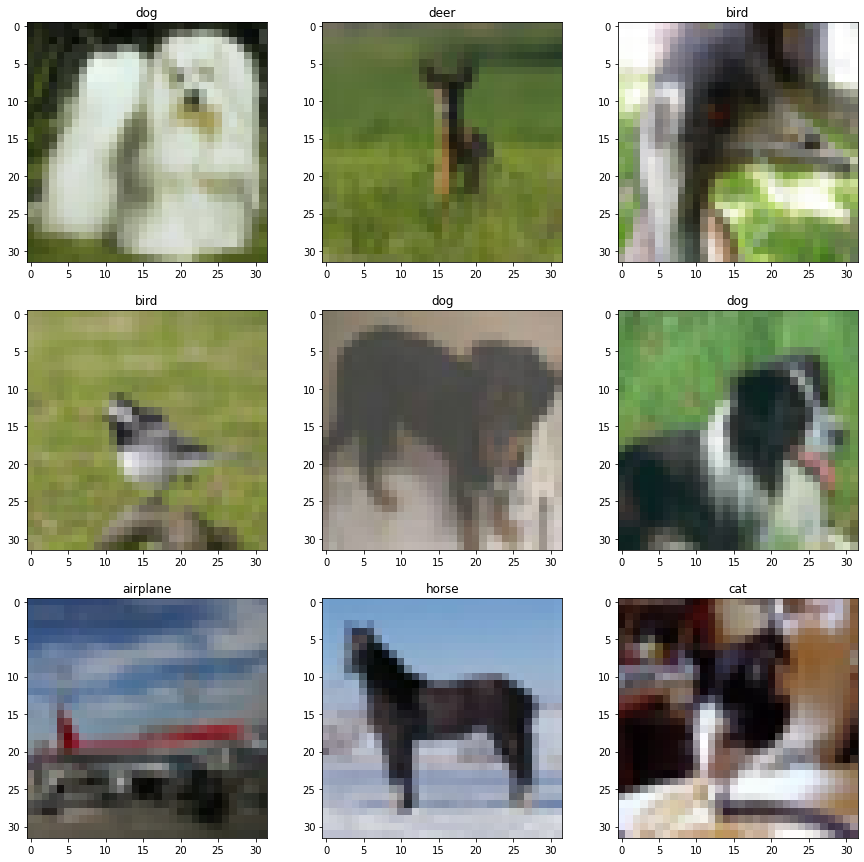

In [18]:
def display(dataset = trainset):
    # 展示一下数据集
    import matplotlib.pyplot as plt
    import numpy as np

    indexs = np.random.randint(0, len(dataset), 9)

    imgs = [dataset.data[i] for i in indexs]
    labels = [dataset.targets[i] for i in indexs]
    classes = dataset.classes

    fig = plt.figure(figsize=(15, 15))
    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1)
        ax.imshow(imgs[i])
        ax.set_title(classes[labels[i]])

display()

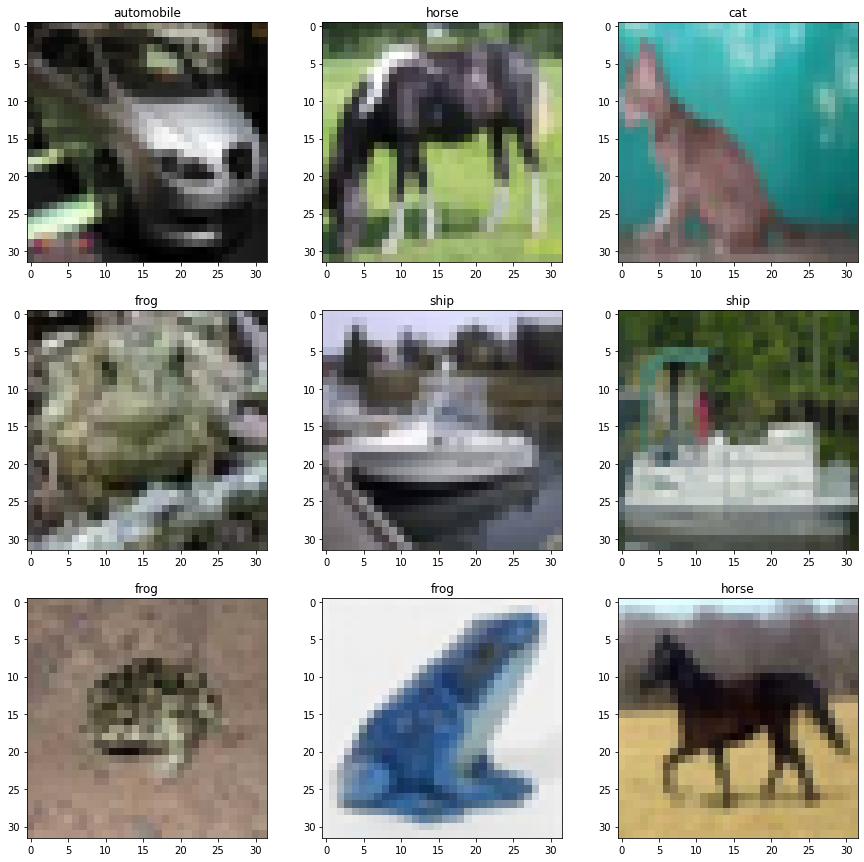

In [19]:
display(testset)

## 加载预训练模型

In [20]:
## 加载预训练模型VGG16
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

# 加载预训练模型
net = models.vgg16(weights=models.VGG16_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\dongl/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:46<00:00, 5.19MB/s]   


In [23]:
# 用原始的 VGG16 模型进行预测看一下分类出的是哪一类
with torch.no_grad():
    sample_image = trainset[0][0].unsqueeze(0)
    res = net(sample_image)
    print(res[0].argmax())
    print(trainset.classes[trainset[0][1]])
    

tensor(103)
frog


> 我们在 https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a 网站上看到了103类是鸭嘴兽，但实际上是青蛙

## 查看模型架构

In [25]:
from torchinfo import summary
summary(net, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

torch.Size([1, 512, 7, 7])


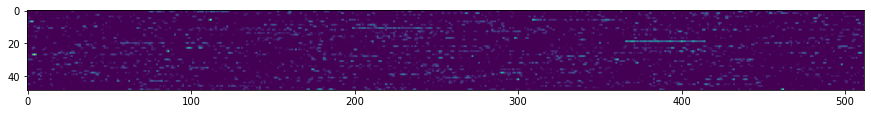

In [29]:
## 查看模型提取的特征
import matplotlib.pyplot as plt
with torch.no_grad():        
    res = net.features(sample_image).cpu()
    plt.figure(figsize=(15, 3))
    plt.imshow(res.detach().view(-1,512))
    print(res.size())

## 先用一个小demo试一下

我们在VGG16预训练模型已经提取了很多特征了，现在我们在不知道VGG16对CIFAR10的分类效果如何的情况下，我们先用一个小的demo来看一下VGG16的效果。

我们的想法是先取800个的数据出来提取feature，然后用这些feature来训练一个分类器，看看这个分类器的效果如何。

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
batch_size = 8
train_size = batch_size * 100 # 先用 800 个训练样本练一下看看
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

feature_tensor = torch.zeros((train_size, 512*7*7)).to(device)
label_tensor = torch.zeros((train_size)).to(device)

sample_cnt = 0
for i, data in enumerate(train_loader):
    inputs, labels = data
    with torch.no_grad():
        features = net.features(inputs.to(device))
        features = features.view(features.size(0), -1)
        feature_tensor[sample_cnt:sample_cnt+batch_size] = features
        label_tensor[sample_cnt:sample_cnt+batch_size] = labels
        sample_cnt += batch_size
        print('.',end='')
    if sample_cnt >= train_size:
        break


....................................................................................................

In [33]:
feature_tensor.shape, label_tensor.shape

(torch.Size([800, 25088]), torch.Size([800]))

### 写一个小的线性层训练一下

In [38]:
### 下面训练和验证的代码部分参考了微软家的pytorch教程
# https://learn.microsoft.com/en-us/training/modules/intro-computer-vision-pytorch/6-transfer-learning
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(device)
        out = net(features.to(device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==lbls).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(device)
            out = net(features.to(device))
            loss += loss_fn(out,lbls) 
            pred = torch.max(out,1)[1]
            acc += (pred==lbls).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res


交叉熵函数

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
          l_n = - w_{y_n} \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
          \cdot \mathbb{1}\{y_n \not= \text{ignore\_index}\}
$$

In [54]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

trainloader = torch.utils.data.DataLoader(train_ds,batch_size=32)
testloader = torch.utils.data.DataLoader(test_ds,batch_size=32)

classifier = torch.nn.Linear(512*7*7,10).to(device) # 10 个分类 最简单的线性分类器
loss_fn = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(classifier.parameters(),lr=0.001) # 使用 Adam 优化器

In [55]:
history = train(classifier,trainloader,testloader,optimizer=optimizer,epochs=10,loss_fn=loss_fn)

Epoch  0, Train acc=0.526, Val acc=0.780, Train loss=0.049, Val loss=0.025
Epoch  1, Train acc=0.984, Val acc=0.770, Train loss=0.002, Val loss=0.023
Epoch  2, Train acc=0.996, Val acc=0.740, Train loss=0.001, Val loss=0.028
Epoch  3, Train acc=1.000, Val acc=0.770, Train loss=0.000, Val loss=0.026
Epoch  4, Train acc=1.000, Val acc=0.780, Train loss=0.000, Val loss=0.023
Epoch  5, Train acc=1.000, Val acc=0.790, Train loss=0.000, Val loss=0.023
Epoch  6, Train acc=1.000, Val acc=0.790, Train loss=0.000, Val loss=0.024
Epoch  7, Train acc=1.000, Val acc=0.790, Train loss=0.000, Val loss=0.024
Epoch  8, Train acc=1.000, Val acc=0.790, Train loss=0.000, Val loss=0.024
Epoch  9, Train acc=1.000, Val acc=0.790, Train loss=0.000, Val loss=0.024


> 这里我们用了800个数据就可以训练出78%的准确率，这个结果还是比较不错的（至少比之前辛辛苦苦的AlexNet达到的75%要好了），但是我们还是想看看完整VGG16的效果。
> 一是说明VGG16的特征提取能力很强，二也可能一部分原因在于我们做数据增强做的不错。

## 迁移学习

这一部分我们要做几件事：
- **替换最终的分类器**
- **冻结卷积特征提取器的权重**
- **微调**，fine-tuning~

### 冻结卷积特征提取器的权重

在下面这个cell的输出可以看到可以训练的参数小了很多。

In [57]:
net.classifier = torch.nn.Linear(25088,10).to(device)

for x in net.features.parameters():
    x.requires_grad = False

summary(net,(1, 3,244,244))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

In [58]:
def train_long(net,train_loader,test_loader,epochs=5,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(),print_freq=10):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    for epoch in range(epochs):
        net.train()
        total_loss,acc,count = 0,0,0
        for i, (features,labels) in enumerate(train_loader):
            lbls = labels.to(device)
            optimizer.zero_grad()
            out = net(features.to(device))
            loss = loss_fn(out,lbls)
            loss.backward()
            optimizer.step()
            total_loss+=loss
            _,predicted = torch.max(out,1)
            acc+=(predicted==lbls).sum()
            count+=len(labels)
            if i%print_freq==0:
                print("Epoch {}, minibatch {}: train acc = {}, train loss = {}".format(epoch,i,acc.item()/count,total_loss.item()/count))
        vl,va = validate(net,test_loader,loss_fn)
        print("Epoch {} done, validation acc = {}, validation loss = {}".format(epoch,va,vl))

In [59]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=False, num_workers=2)

train_long(net,trainloader,testloader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=2,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.15625, train loss = 0.07249166816473007


KeyboardInterrupt: 

In [61]:
net = torch.load('data/vgg_cifar10.pth',map_location=torch.device('cpu'))

# 保存模型
# torch.save(net,'data/vgg_cifar10.pth')

In [62]:
validate(net,testloader,loss_fn=torch.nn.CrossEntropyLoss())

(0.1367221435546875, 0.8306)

> 在本地没有GPU的情况下，我们做个验证都需要跑19m39s，而在colab上做验证只花了54s的时间